In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import itertools
import tensorflow as tf
import tensorflow_hub as hub

In [43]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Flatten, 
                                     Conv1D, MaxPooling1D, Dropout, 
                                     GlobalMaxPooling1D, Activation, 
                                     Embedding, Bidirectional, LSTM, 
                                     BatchNormalization)

In [44]:
from collections import Counter
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (classification_report,accuracy_score,
                             precision_score,recall_score,f1_score, 
                             confusion_matrix, precision_recall_curve)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   LabelBinarizer)

In [45]:
data = pd.read_csv('pdb_data_no_dups.csv')
seq = pd.read_csv('pdb_data_seq.csv')

In [46]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [47]:
seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [48]:
# select only protein for macromolecule type
data = data[data.macromoleculeType == 'Protein']

In [49]:
# delete columns macromoleculeType, residueCount, structureId
data = data.drop(['macromoleculeType',
                  'pdbxDetails',
                  'structureId'], axis=1)

In [50]:
data['experimentalTechnique'].value_counts()

X-RAY DIFFRACTION                                            115438
SOLUTION NMR                                                  10524
ELECTRON MICROSCOPY                                            1423
SOLID-STATE NMR                                                  97
ELECTRON CRYSTALLOGRAPHY                                         73
NEUTRON DIFFRACTION                                              58
NEUTRON DIFFRACTION, X-RAY DIFFRACTION                           38
X-RAY DIFFRACTION, NEUTRON DIFFRACTION                           32
SOLUTION SCATTERING                                              28
FIBER DIFFRACTION                                                22
POWDER DIFFRACTION                                               19
SOLUTION SCATTERING, SOLUTION NMR                                 7
X-RAY DIFFRACTION, EPR                                            5
SOLUTION NMR, THEORETICAL MODEL                                   5
SOLUTION NMR, SOLUTION SCATTERING               

In [51]:
counts = data.experimentalTechnique.value_counts()
hello = np.asarray(counts[(counts > 96)].index)

In [52]:
data = data[data.experimentalTechnique.isin(hello)]
data.head()

,classification,experimentalTechnique,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear
2,OXYGEN TRANSPORT,X-RAY DIFFRACTION,154,2.07,18112.80,NaN,NaN,3.09,60.20,9.0,1999.0
4,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,1993.0
5,OXYGEN TRANSPORT,X-RAY DIFFRACTION,154,1.84,18010.64,NaN,NaN,3.09,60.20,9.0,1999.0
7,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,1993.0
8,OXYGEN TRANSPORT,X-RAY DIFFRACTION,154,2.07,18093.78,NaN,NaN,3.09,60.30,9.0,1999.0


In [53]:
data['crystallizationMethod'].value_counts()[:20]

VAPOR DIFFUSION, HANGING DROP              48881
VAPOR DIFFUSION, SITTING DROP              28005
VAPOR DIFFUSION                             4917
EVAPORATION                                  888
MICROBATCH                                   834
hanging drop                                 339
LIPIDIC CUBIC PHASE                          336
SMALL TUBES                                  257
MICRODIALYSIS                                256
BATCH MODE                                   255
LIQUID DIFFUSION                             250
VAPOR DIFFUSION,SITTING DROP,NANODROP        207
batch                                        144
microbatch under oil                         120
VAPOR DIFFUSION, SITTING DROP, NANODROP      106
BATCH                                         76
MICROBATCH UNDER OIL                          61
sitting drop                                  59
Microbatch under oil                          45
Batch                                         44
Name: crystallizatio

In [54]:
counts = data.crystallizationMethod.value_counts()
hello = np.asarray(counts[(counts > 100)].index)

In [55]:
data = data[data.crystallizationMethod.isin(hello)]
data.head()

,classification,experimentalTechnique,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear
96,KINASE,X-RAY DIFFRACTION,1660,2.50,181547.91,VAPOR DIFFUSION,NaN,2.90,60.87,8.0,1997.0
159,KINASE,X-RAY DIFFRACTION,415,1.60,45571.57,VAPOR DIFFUSION,NaN,2.64,53.00,7.7,1998.0
205,ALU DOMAIN,X-RAY DIFFRACTION,232,2.53,26562.73,hanging drop,277.0,3.00,34.00,7.7,1997.0
224,TRANSFERASE,X-RAY DIFFRACTION,418,1.90,49082.30,hanging drop,NaN,2.57,52.06,6.0,1999.0
230,SIGNAL TRANSDUCTION PROTEIN,X-RAY DIFFRACTION,430,2.20,47657.25,"VAPOR DIFFUSION, SITTING DROP",277.0,2.49,51.03,7.6,1998.0


In [56]:
data["crystallizationMethod"].replace({"VAPOR DIFFUSION, HANGING DROP" : "VAPOR DIFFUSION", 
                                       "VAPOR DIFFUSION, SITTING DROP" : "VAPOR DIFFUSION", 
                                       "VAPOR DIFFUSION" : "VAPOR DIFFUSION", 
                                       "EVAPORATION" : "EVAPORATION", 
                                       "MICROBATCH" : "MICROBATCH", 
                                       "hanging drop" : "VAPOR DIFFUSION", 
                                       "LIPIDIC CUBIC PHASE" : "LIPIDIC CUBIC PHASE", 
                                       "SMALL TUBES" : "Miscellaneous", 
                                       "MICRODIALYSIS" : "MICRODIALYSIS", 
                                       "BATCH MODE" : "MICROBATCH", 
                                       "LIQUID DIFFUSION" : "Miscellaneous", 
                                       "VAPOR DIFFUSION,SITTING DROP,NANODROP" : "VAPOR DIFFUSION", 
                                       "batch" : "MICROBATCH", 
                                       "microbatch under oil" : "MICROBATCH", 
                                       "VAPOR DIFFUSION, SITTING DROP, NANODROP" : "VAPOR DIFFUSION"}, 
                                      inplace=True)

In [57]:
data['crystallizationMethod'].value_counts()

VAPOR DIFFUSION        82455
MICROBATCH              1353
EVAPORATION              888
Miscellaneous            507
LIPIDIC CUBIC PHASE      336
MICRODIALYSIS            256
Name: crystallizationMethod, dtype: int64

In [58]:
data['classification'].value_counts()[:20]

HYDROLASE                                14586
TRANSFERASE                              11321
OXIDOREDUCTASE                            8643
LYASE                                     3370
IMMUNE SYSTEM                             3259
TRANSPORT PROTEIN                         2375
TRANSCRIPTION                             2275
HYDROLASE/HYDROLASE INHIBITOR             2040
ISOMERASE                                 1879
SIGNALING PROTEIN                         1864
TRANSFERASE/TRANSFERASE INHIBITOR         1581
LIGASE                                    1544
VIRAL PROTEIN                             1359
PROTEIN BINDING                           1252
STRUCTURAL GENOMICS, UNKNOWN FUNCTION     1146
MEMBRANE PROTEIN                          1044
SUGAR BINDING PROTEIN                     1010
UNKNOWN FUNCTION                           935
DNA BINDING PROTEIN                        909
METAL BINDING PROTEIN                      830
Name: classification, dtype: int64

In [59]:
counts = data.classification.value_counts()
hello = np.asarray(counts[(counts > 829)].index)

In [60]:
data = data[data.classification.isin(hello)]

In [61]:
missing_data = []

for col in data.columns:
    if data[col].isnull().sum() > 0:
        missing_data.append(col)
    
missing_data

['resolution',
 'crystallizationTempK',
 'densityMatthews',
 'densityPercentSol',
 'phValue',
 'publicationYear']

In [62]:
# replace null values in numeric vars with mean: 
# resolution, crystallizationMethod, crystallizationTempK,
# densityMatthews, densityPercentSol, phValue, publicationYear

def impute_mean(df, col):
    mean_val=df[col].mean()
    df[col].fillna(mean_val,inplace=True)

In [63]:
impute_mean(data, 'resolution')
impute_mean(data, 'crystallizationTempK')
impute_mean(data, 'densityMatthews')
impute_mean(data, 'densityPercentSol')
impute_mean(data, 'phValue')
impute_mean(data, 'publicationYear')

In [64]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount,63222.0,750.535636,939.836898,7.00,296.00,485.000000,868.00,57792.00
resolution,63222.0,2.100655,0.539171,0.48,1.75,2.000000,2.40,10.00
structureMolecularWeight,63222.0,84765.852948,103938.621116,836.81,33813.86,55024.795000,97835.54,4918807.00
crystallizationTempK,63222.0,290.981367,8.534965,4.00,290.00,293.000000,295.00,398.00
densityMatthews,63222.0,2.641340,0.657995,0.00,2.22,2.470000,2.86,13.89
densityPercentSol,63222.0,51.146664,9.559680,0.00,44.47,50.200000,57.00,92.00
phValue,63222.0,6.788657,1.255814,0.00,6.00,6.788657,7.50,100.00
publicationYear,63222.0,2010.667512,4.520523,1988.00,2008.00,2010.667512,2014.00,2018.00


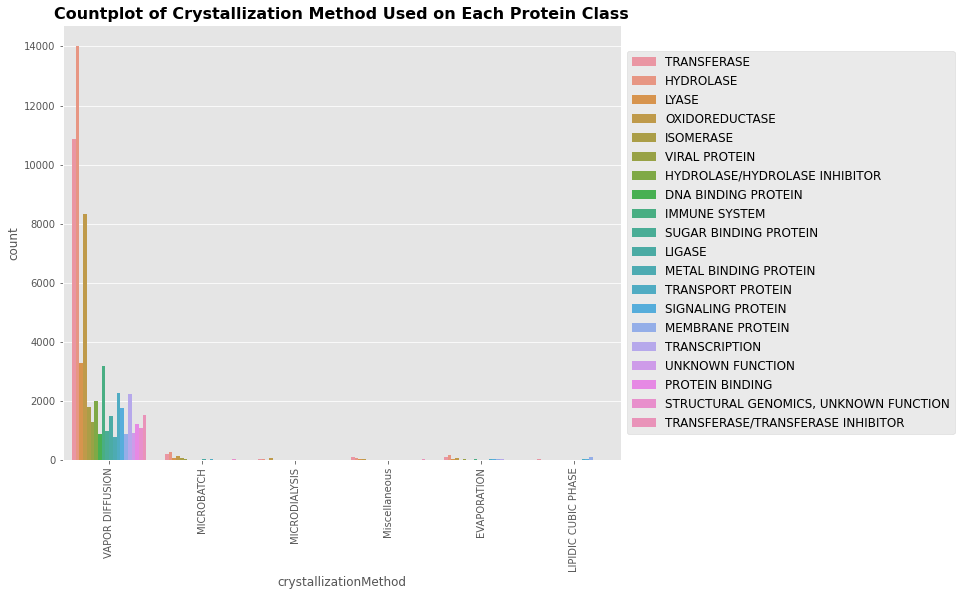

In [65]:
# count plots of crystallizationMethod vs. classification

plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.xlabel('crystallization method', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title("Countplot of Crystallization Method Used on Each Protein Class",fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
g = sns.countplot(x=data['crystallizationMethod'], data=data, hue='classification')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

In [66]:
# crystallization method and experimental technique do not matter
# only feed numerical values to model

data = data.drop(['crystallizationMethod',
                  'experimentalTechnique'], 
                  axis=1)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63222 entries, 224 to 141319
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   classification            63222 non-null  object 
 1   residueCount              63222 non-null  int64  
 2   resolution                63222 non-null  float64
 3   structureMolecularWeight  63222 non-null  float64
 4   crystallizationTempK      63222 non-null  float64
 5   densityMatthews           63222 non-null  float64
 6   densityPercentSol         63222 non-null  float64
 7   phValue                   63222 non-null  float64
 8   publicationYear           63222 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

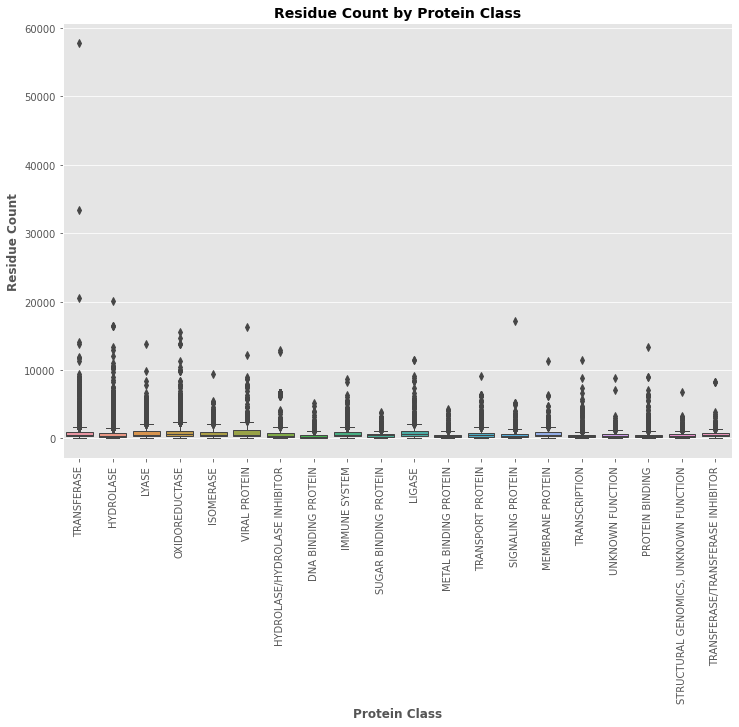

In [68]:
# boxplots
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['residueCount'], x=data['classification'], linewidth=1)
plt.title('Residue Count by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Residue Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

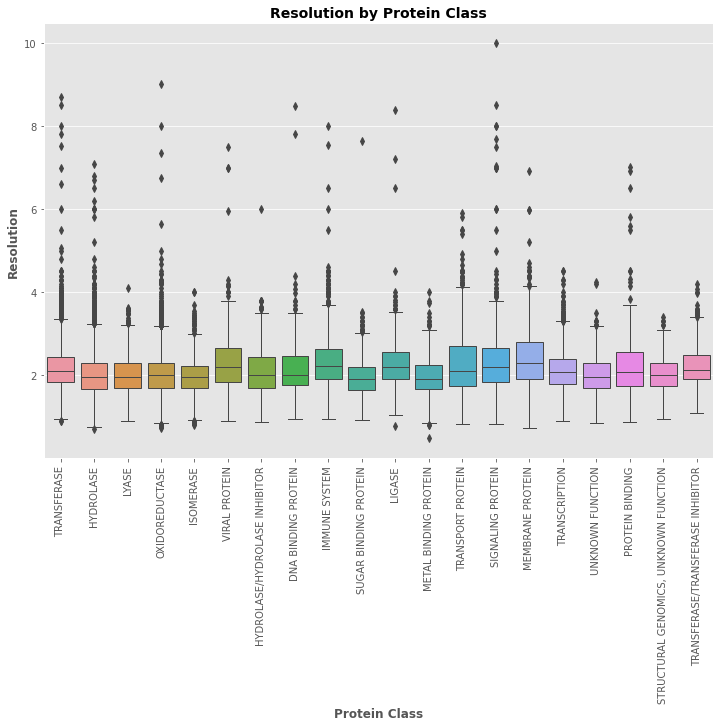

In [69]:
# boxplots
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['resolution'], x=data['classification'], linewidth=1)
#plt.ylim(0.5,4)
plt.title('Resolution by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Resolution', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

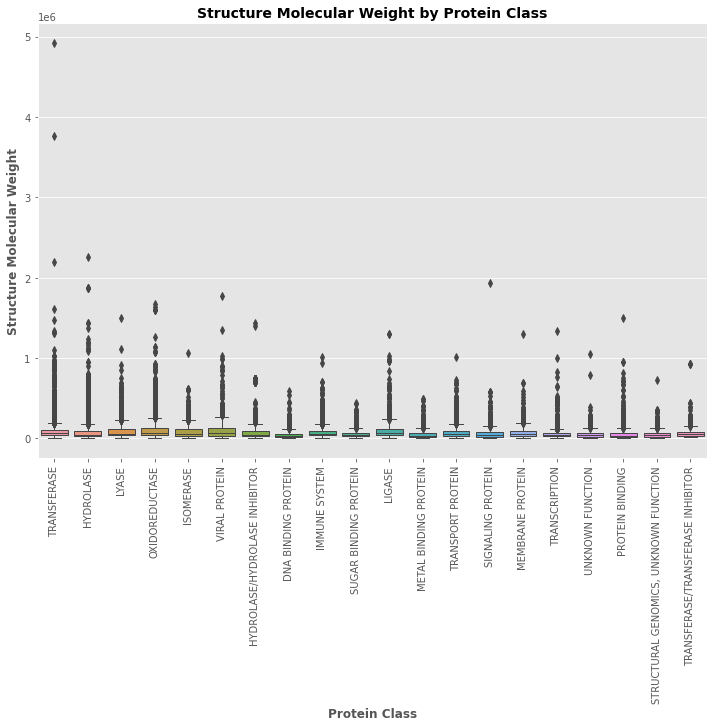

In [70]:
# structureMolecularWeight
# boxplots
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['structureMolecularWeight'], x=data['classification'], linewidth=1)
#plt.ylim(0,300000)
plt.title('Structure Molecular Weight by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Structure Molecular Weight', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

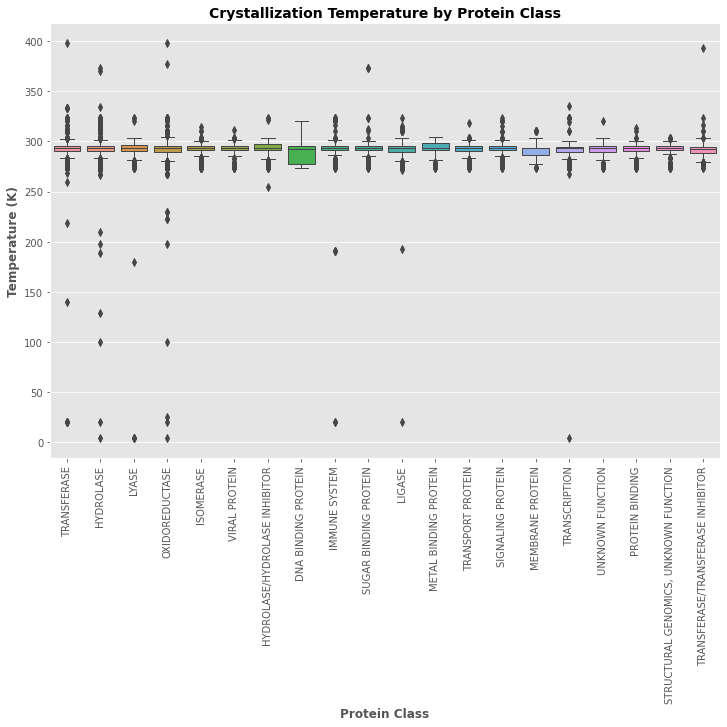

In [71]:
#crystallizationTempK
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['crystallizationTempK'], x=data['classification'], linewidth=1)
#plt.ylim(280,300)
plt.title('Crystallization Temperature by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('Temperature (K)', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

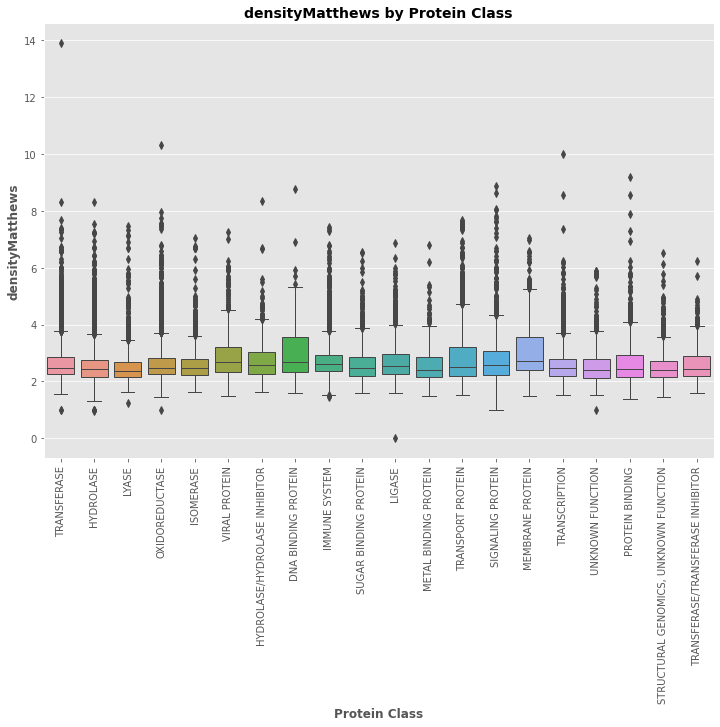

In [72]:
#densityMatthews
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['densityMatthews'], x=data['classification'], linewidth=1)
#plt.ylim(1.5,4)
plt.title('densityMatthews by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('densityMatthews', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

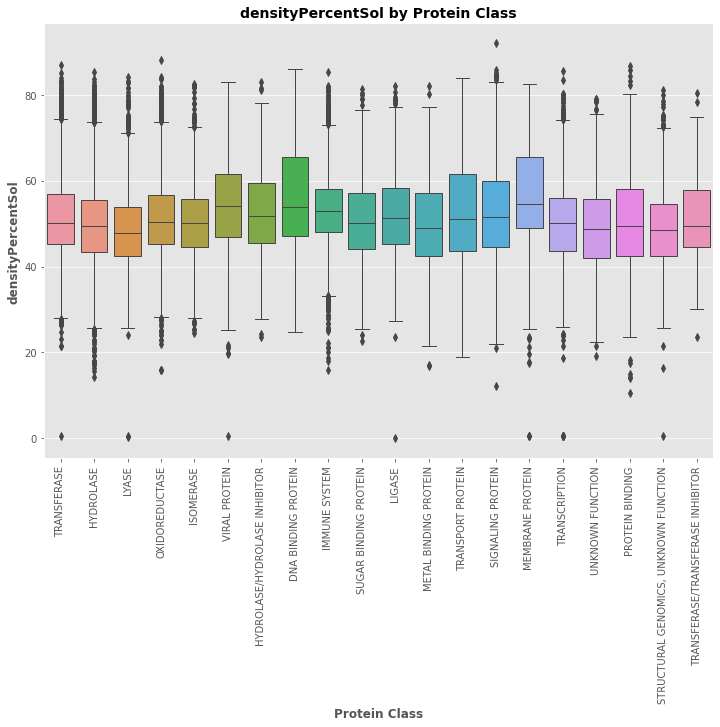

In [73]:
#densityPercentSol
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['densityPercentSol'], x=data['classification'], linewidth=1)
#plt.ylim(23, 70)
plt.title('densityPercentSol by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('densityPercentSol', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

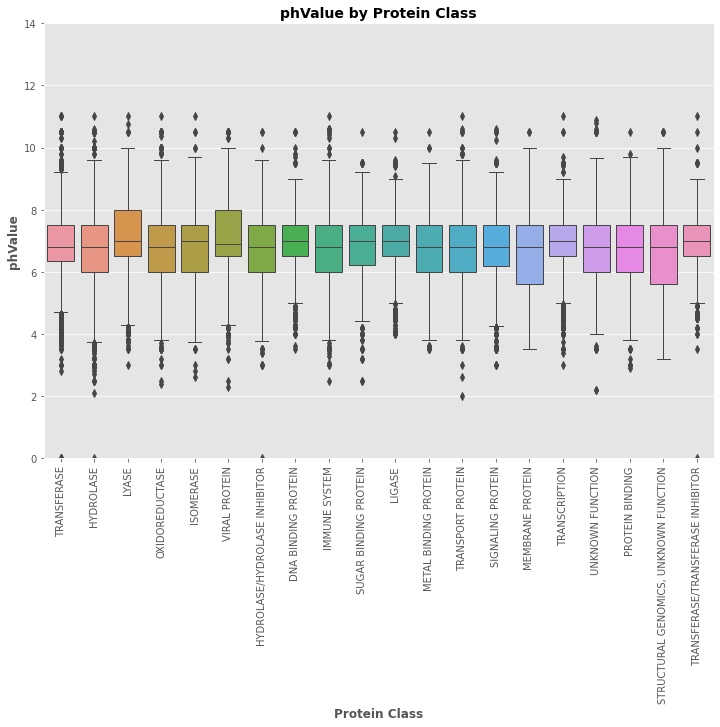

In [74]:
#phValue
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['phValue'], x=data['classification'], linewidth=1)
plt.ylim(0,14)
plt.title('phValue by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('phValue', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TRANSFERASE'),
  Text(1, 0, 'HYDROLASE'),
  Text(2, 0, 'LYASE'),
  Text(3, 0, 'OXIDOREDUCTASE'),
  Text(4, 0, 'ISOMERASE'),
  Text(5, 0, 'VIRAL PROTEIN'),
  Text(6, 0, 'HYDROLASE/HYDROLASE INHIBITOR'),
  Text(7, 0, 'DNA BINDING PROTEIN'),
  Text(8, 0, 'IMMUNE SYSTEM'),
  Text(9, 0, 'SUGAR BINDING PROTEIN'),
  Text(10, 0, 'LIGASE'),
  Text(11, 0, 'METAL BINDING PROTEIN'),
  Text(12, 0, 'TRANSPORT PROTEIN'),
  Text(13, 0, 'SIGNALING PROTEIN'),
  Text(14, 0, 'MEMBRANE PROTEIN'),
  Text(15, 0, 'TRANSCRIPTION'),
  Text(16, 0, 'UNKNOWN FUNCTION'),
  Text(17, 0, 'PROTEIN BINDING'),
  Text(18, 0, 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'),
  Text(19, 0, 'TRANSFERASE/TRANSFERASE INHIBITOR')])

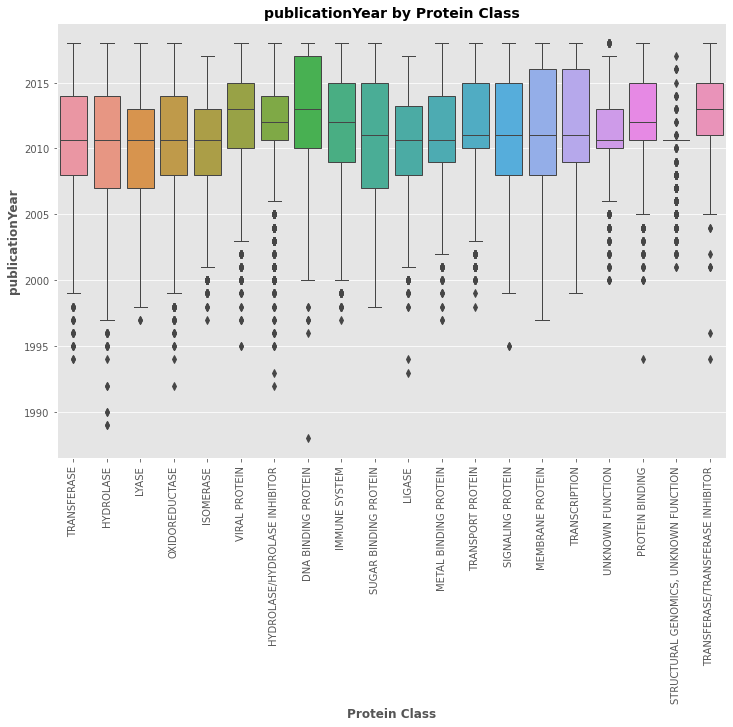

In [75]:
#publicationYear
plt.style.use('ggplot')
ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=data['publicationYear'], x=data['classification'], linewidth=1)
#plt.ylim(1990, 2020)
plt.title('publicationYear by Protein Class', fontsize=14, fontweight='bold')
plt.xlabel('Protein Class', fontsize=12, fontweight='bold')
plt.ylabel('publicationYear', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)

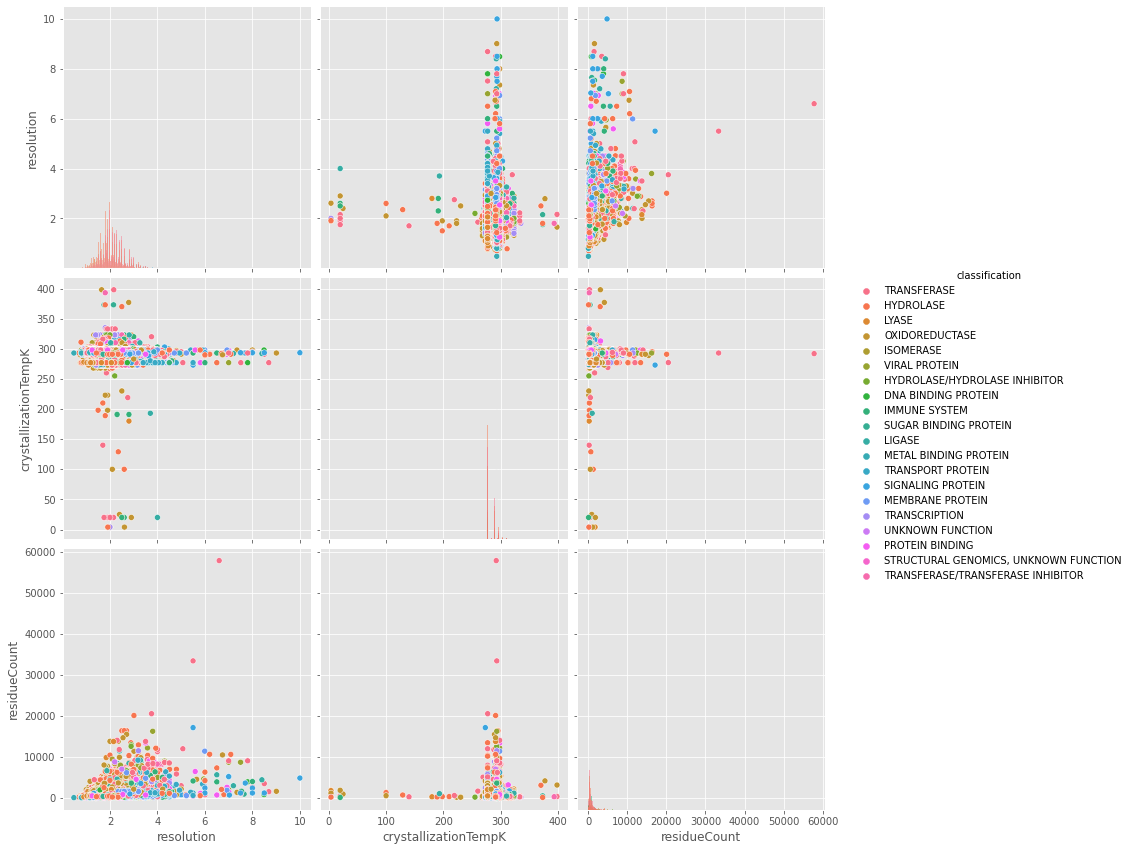

In [76]:
sns.pairplot(data[['resolution', 
                   'crystallizationTempK', 
                   'residueCount', 
                   'classification']],
             hue='classification', 
             height=4, 
             diag_kind='hist')

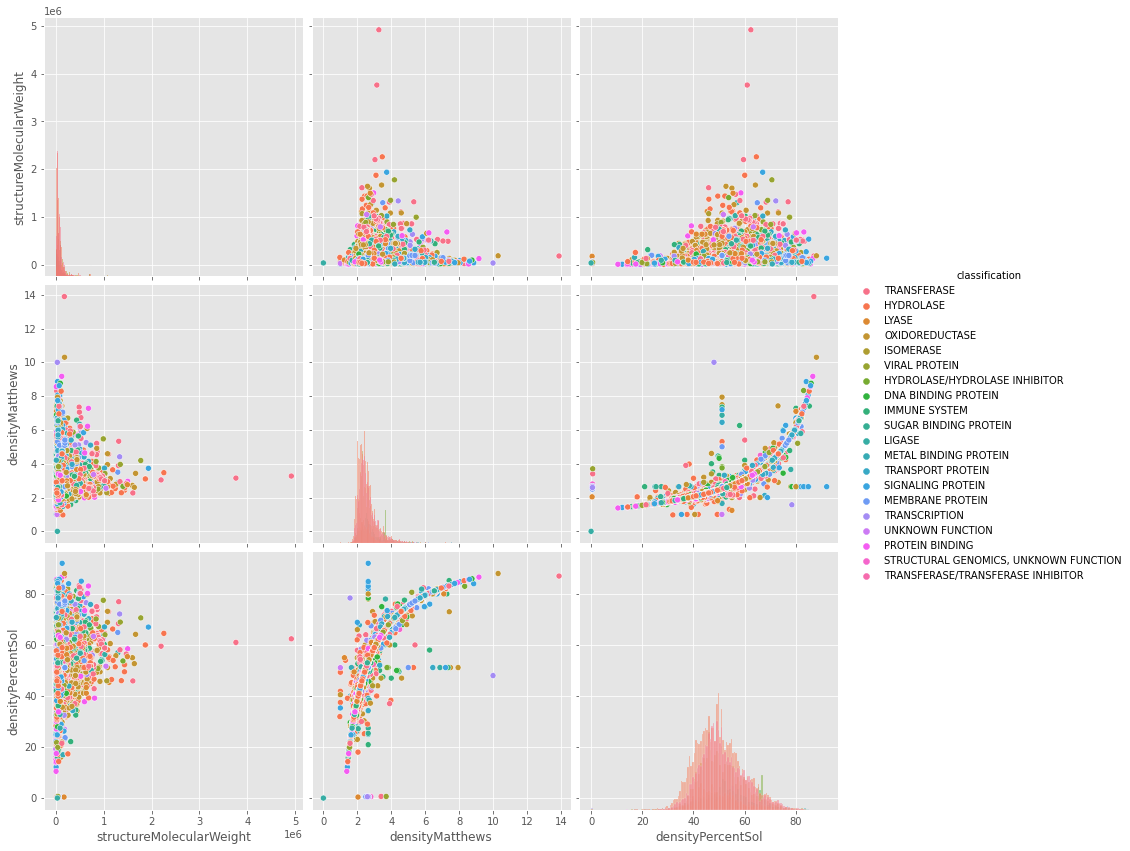

In [77]:
sns.pairplot(data[['structureMolecularWeight', 
                   'densityMatthews', 
                   'densityPercentSol', 
                   'classification']],
             hue='classification', 
             height=4, 
             diag_kind='hist')

In [78]:
data = pd.read_csv('pdb_data_no_dups.csv')
seq = pd.read_csv('pdb_data_seq.csv')

In [79]:
df_intermediate = seq.merge(data, on='structureId', how='left')
df_intermediate.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
2,101D,A,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
3,101D,B,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [80]:
df_intermediate.drop_duplicates(subset=['structureId'], keep='first', inplace=True)
df_intermediate.head()

,structureId,chainId,sequence,residueCount_x,macromoleculeType_x,classification,experimentalTechnique,macromoleculeType_y,residueCount_y,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
2,101D,A,CGCGAATTCGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
5,102D,A,CGCAAATTTGCG,24,DNA,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [81]:
# select only protein for macromolecule type
df_intermediate = df_intermediate[df_intermediate.macromoleculeType_x == 'Protein']

In [82]:
df_intermediate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127387 entries, 4 to 471145
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               127387 non-null  object 
 1   chainId                   127387 non-null  object 
 2   sequence                  127384 non-null  object 
 3   residueCount_x            127387 non-null  int64  
 4   macromoleculeType_x       127387 non-null  object 
 5   classification            127386 non-null  object 
 6   experimentalTechnique     127387 non-null  object 
 7   macromoleculeType_y       127387 non-null  object 
 8   residueCount_y            127387 non-null  int64  
 9   resolution                116602 non-null  float64
 10  structureMolecularWeight  127387 non-null  float64
 11  crystallizationMethod     87325 non-null   object 
 12  crystallizationTempK      88287 non-null   float64
 13  densityMatthews           114122 non-null  f

In [83]:
# delete columns macromoleculeType, residueCount, structureId
df_intermediate = df_intermediate.drop(['macromoleculeType_x',
                                        'macromoleculeType_y',
                                        'chainId',
                                        'residueCount_x',
                                        'residueCount_y',
                                        'resolution',
                                        'structureMolecularWeight',
                                        'crystallizationMethod',
                                        'crystallizationTempK',
                                        'densityMatthews',
                                        'densityPercentSol',
                                        'phValue',
                                        'publicationYear',
                                        'pdbxDetails',
                                        'structureId',
                                        'experimentalTechnique'], axis=1)

In [84]:
df_intermediate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127387 entries, 4 to 471145
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   sequence        127384 non-null  object
 1   classification  127386 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [85]:
def impute_mode(df, col):
    mode_category=df[col].mode()[0]
    df[col].fillna(mode_category,inplace=True)

In [86]:
impute_mode(df_intermediate, 'sequence')

In [87]:
impute_mode(df_intermediate, 'classification')

In [88]:
data = df_intermediate

In [89]:
data.head()

,sequence,classification
4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
7,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,HYDROLASE(O-GLYCOSYL)
8,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
11,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,HYDROLASE(O-GLYCOSYL)
12,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT


In [90]:
data['seq_char_count']= data['sequence'].apply(lambda x: len(x))

In [91]:
def plot_seq_count(df):
    sns.distplot(df['seq_char_count'].values, color='b')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Sequence Character Count')
    plt.grid(True)

C:\Users\limbu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


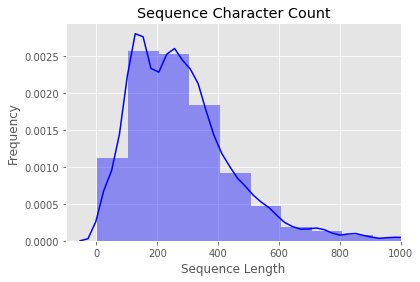

In [92]:
plt.style.use('ggplot')
plot_seq_count(data)
plt.xlim(-100,1000)
plt.show()

In [93]:
def get_code_freq(df):
    
    df = df.apply(lambda x: " ".join(x))
    
    codes = []
    
    for i in df: # concatination of all codes
        codes.extend(i)

    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space
    
    df = pd.DataFrame({'Amino Acid': list(codes_dict.keys()), 'Frequency': list(codes_dict.values())})
    return df.sort_values('Frequency', ascending=False).reset_index()[['Amino Acid', 'Frequency']]

In [94]:
code_freq = get_code_freq(data['sequence'])
code_freq

,Amino Acid,Frequency
0,L,3299786
1,A,2858951
2,G,2712474
3,V,2499381
4,E,2364910
5,S,2310140
6,K,2097751
7,D,2095220
8,T,2029384
9,I,2008386


In [95]:
def plot_code_freq(df):
    plt.title('Amino Acid Frequency')
    sns.barplot(x='Amino Acid', y='Frequency', data=df)

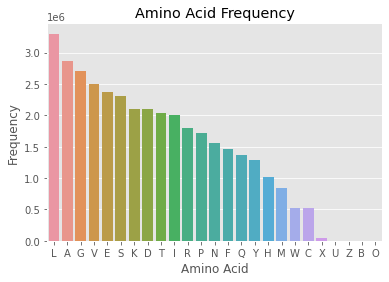

In [96]:
plot_code_freq(code_freq)
plt.show()

In [97]:
sequences = data.sequence.values
lengths = [len(s) for s in sequences]

In [98]:
# mean length of a sequence - will use this as a max input length for models
np.mean(lengths)

285.9119062384702

In [99]:
data['classification'].value_counts()[:20]

HYDROLASE                                20383
TRANSFERASE                              15340
OXIDOREDUCTASE                           12173
LYASE                                     4239
IMMUNE SYSTEM                             3989
TRANSCRIPTION                             3479
TRANSPORT PROTEIN                         3174
SIGNALING PROTEIN                         2845
HYDROLASE/HYDROLASE INHIBITOR             2650
ISOMERASE                                 2531
VIRAL PROTEIN                             2257
LIGASE                                    2076
PROTEIN BINDING                           1867
MEMBRANE PROTEIN                          1708
TRANSFERASE/TRANSFERASE INHIBITOR         1682
STRUCTURAL GENOMICS, UNKNOWN FUNCTION     1647
DNA BINDING PROTEIN                       1413
METAL BINDING PROTEIN                     1342
SUGAR BINDING PROTEIN                     1318
CELL ADHESION                             1274
Name: classification, dtype: int64

In [100]:
# only keep top 20 classifications
counts = data.classification.value_counts()
hello = np.asarray(counts[(counts > 1273)].index)

In [101]:
data = data[data.classification.isin(hello)]

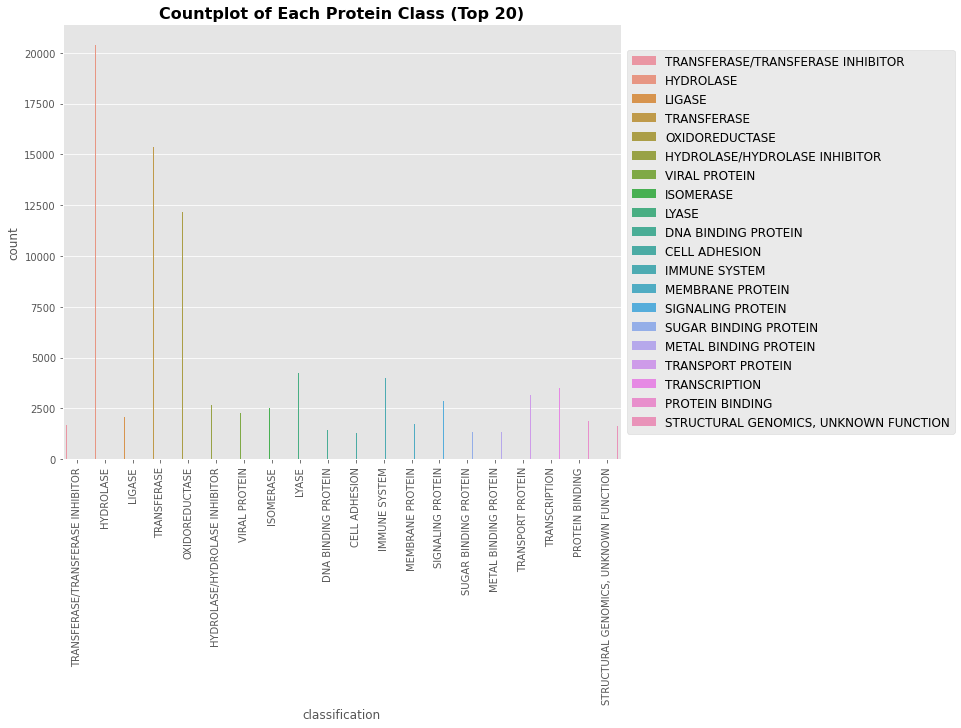

In [102]:
# count plot of classification
plt.style.use('ggplot')
plt.figure(figsize=(10,8))
plt.xlabel('classification', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title("Countplot of Each Protein Class (Top 20)",fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
g = sns.countplot(x=data['classification'], data=data, hue='classification')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

In [103]:
X = data['sequence']
y = data['classification']

In [104]:
# encode classification labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [105]:
# encode sequences using tokenizer
# create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
# represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=285)

In [106]:
# number of distinct characters stored in variable max_id
# this will be part of the input shape (reps each AA)
max_id = len(tokenizer.word_index)
max_id

25

In [107]:
# total number of characters 
dataset_size = tokenizer.document_count
dataset_size

87387

In [108]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

In [109]:
# confirm shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69909, 285), (17478, 285), (69909, 20), (17478, 20))

In [110]:
def plot_model_results(model):
    
    accuracy = model.history.history['accuracy']
    loss = model.history.history['loss']
    
    val_accuracy = model.history.history['val_accuracy']
    val_loss = model.history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    
    plt.ylabel('% accuracy')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    
    plt.ylabel('% loss')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.show()

In [111]:
# create the model
model_0 = Sequential()

# embedding layer takes 3 args: 26 (25 AAs + 1), 20 (output vector shape = classes), 285 (max length of sequence)
model_0.add(Embedding(26, 20, input_length=285))

# This layer creates a convolution kernel that is convolved with the 
# layer input over a single spatial (or temporal) dimension to 
# produce a tensor of outputs.
model_0.add(Conv1D(filters=128, kernel_size=12, padding='same', activation='relu'))
model_0.add(MaxPooling1D(pool_size=2))

model_0.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model_0.add(MaxPooling1D(pool_size=2))

model_0.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_0.add(MaxPooling1D(pool_size=2))

model_0.add(Flatten())
model_0.add(Dense(1120, activation='relu'))
model_0.add(Dense(20, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode= 'max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_0.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 285, 20)           520       
                                                                 
 conv1d (Conv1D)             (None, 285, 128)          30848     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 142, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 142, 64)           49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 71, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 71, 32)            6

In [112]:
model_0.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=early_stopping)

Epoch 1/10
2185/2185 [==============================] - 92s 42ms/step - loss: 1.8204 - accuracy: 0.4475 - val_loss: 1.4522 - val_accuracy: 0.5674
Epoch 2/10
2185/2185 [==============================] - 91s 42ms/step - loss: 1.1550 - accuracy: 0.6588 - val_loss: 1.1122 - val_accuracy: 0.6811
Epoch 3/10
2185/2185 [==============================] - 92s 42ms/step - loss: 0.8029 - accuracy: 0.7579 - val_loss: 1.0417 - val_accuracy: 0.7140
Epoch 4/10
2185/2185 [==============================] - 91s 42ms/step - loss: 0.5752 - accuracy: 0.8225 - val_loss: 1.0596 - val_accuracy: 0.7327
Epoch 5/10
2185/2185 [==============================] - 91s 42ms/step - loss: 0.4404 - accuracy: 0.8651 - val_loss: 1.0879 - val_accuracy: 0.7404
Epoch 6/10
2185/2185 [==============================] - 91s 42ms/step - loss: 0.3661 - accuracy: 0.8916 - val_loss: 1.1394 - val_accuracy: 0.7417
Epoch 7/10
2185/2185 [==============================] - 91s 42ms/step - loss: 0.3240 - accuracy: 0.9026 - val_loss: 1.2151 -

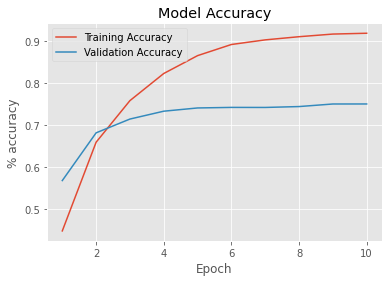

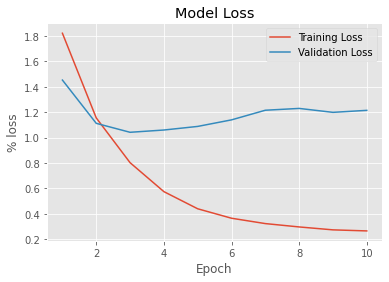

In [113]:
plot_model_results(model_0)

In [114]:
train_pred = model_0.predict(X_train)
test_pred = model_0.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9350584331058948
test accuracy = 0.7499141778235496


In [115]:
# Compute confusion matrix
#cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#np.set_printoptions(precision=2)
#plt.figure(figsize=(7,7))
#plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title('Confusion matrix')
#plt.colorbar()
#tick_marks = np.arange(len(lb.classes_))
#plt.xticks(tick_marks, lb.classes_, rotation=90)
#plt.yticks(tick_marks, lb.classes_)
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
#plt.show()

In [116]:
#print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [117]:
model_1 = Sequential()
model_1.add(Embedding(26, 20, input_length=285))

model_1.add(LSTM(25, return_sequences=True))

model_1.add(Flatten())
model_1.add(Dense(7125, activation='sigmoid'))
model_1.add(Dense(20, activation='softmax'))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 285, 20)           520       
                                                                 
 lstm (LSTM)                 (None, 285, 25)           4600      
                                                                 
 flatten_1 (Flatten)         (None, 7125)              0         
                                                                 
 dense_2 (Dense)             (None, 7125)              50772750  
                                                                 
 dense_3 (Dense)             (None, 20)                142520    
                                                                 
Total params: 50,920,390
Trainable params: 50,920,390
Non-trainable params: 0
_________________________________________________________________


In [118]:
model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 535s 244ms/step - loss: 1.8624 - accuracy: 0.4507 - val_loss: 1.4254 - val_accuracy: 0.5700
Epoch 2/50
2185/2185 [==============================] - 534s 244ms/step - loss: 1.0714 - accuracy: 0.6782 - val_loss: 1.0065 - val_accuracy: 0.7059
Epoch 3/50
2185/2185 [==============================] - 541s 248ms/step - loss: 0.5583 - accuracy: 0.8272 - val_loss: 1.0002 - val_accuracy: 0.7455
Epoch 4/50
2185/2185 [==============================] - 539s 247ms/step - loss: 0.3340 - accuracy: 0.8994 - val_loss: 1.0301 - val_accuracy: 0.7497
Epoch 5/50
2185/2185 [==============================] - 545s 249ms/step - loss: 0.2770 - accuracy: 0.9166 - val_loss: 1.0160 - val_accuracy: 0.7464
Epoch 6/50
2185/2185 [==============================] - 545s 250ms/step - loss: 0.2677 - accuracy: 0.9202 - val_loss: 1.0925 - val_accuracy: 0.7393


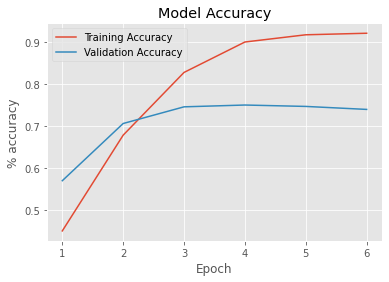

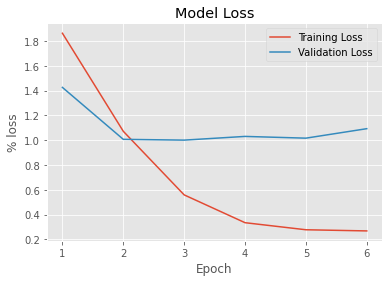

In [119]:
plot_model_results(model_1)

In [120]:
train_pred = model_1.predict(X_train)
test_pred = model_1.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.925846457537656
test accuracy = 0.7497425334706488


C:\Users\limbu\AppData\Local\Temp/ipykernel_17092/2592686746.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


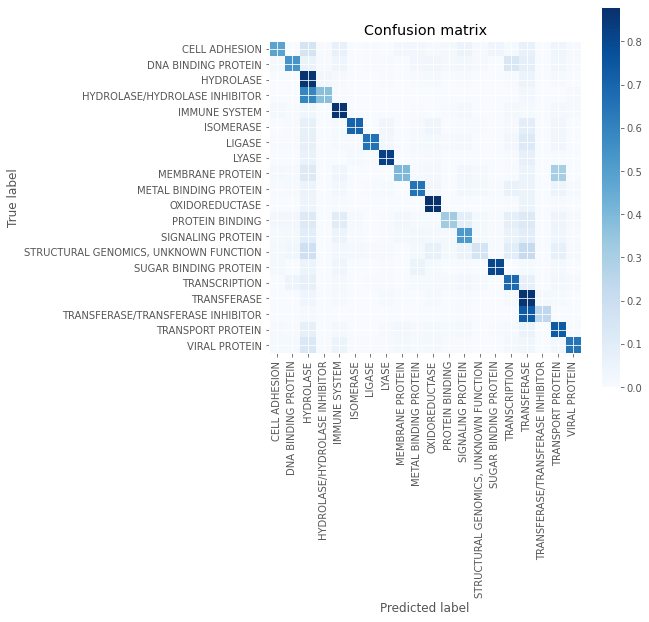

In [121]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [122]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.58      0.48      0.53       226
                  DNA BINDING PROTEIN       0.59      0.54      0.56       280
                            HYDROLASE       0.76      0.86      0.81      4111
        HYDROLASE/HYDROLASE INHIBITOR       0.66      0.37      0.48       536
                        IMMUNE SYSTEM       0.74      0.86      0.80       865
                            ISOMERASE       0.89      0.70      0.79       491
                               LIGASE       0.87      0.66      0.75       435
                                LYASE       0.86      0.82      0.84       827
                     MEMBRANE PROTEIN       0.72      0.40      0.52       336
                METAL BINDING PROTEIN       0.59      0.65      0.62       263
                       OXIDOREDUCTASE       0.91      0.88      0.89      2409
                      PROTEIN BINDING       0.67   

In [123]:
model_2 = Sequential()
model_2.add(Embedding(26, 20, input_length=285))

model_2.add(Bidirectional(LSTM(10, return_sequences=True)))

model_2.add(Flatten())
model_2.add(Dense(5700, activation='sigmoid'))
model_2.add(Dense(20, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 285, 20)           520       
                                                                 
 bidirectional (Bidirectiona  (None, 285, 20)          2480      
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 5700)              0         
                                                                 
 dense_4 (Dense)             (None, 5700)              32495700  
                                                                 
 dense_5 (Dense)             (None, 20)                114020    
                                                                 
Total params: 32,612,720
Trainable params: 32,612,720
Non-trainable params: 0
__________________________________________

In [124]:
model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 403s 182ms/step - loss: 1.8480 - accuracy: 0.4544 - val_loss: 1.4371 - val_accuracy: 0.5708
Epoch 2/50
2185/2185 [==============================] - 397s 182ms/step - loss: 1.1154 - accuracy: 0.6676 - val_loss: 1.0565 - val_accuracy: 0.7002
Epoch 3/50
2185/2185 [==============================] - 397s 182ms/step - loss: 0.6082 - accuracy: 0.8127 - val_loss: 0.9250 - val_accuracy: 0.7401
Epoch 4/50
2185/2185 [==============================] - 397s 182ms/step - loss: 0.3496 - accuracy: 0.8927 - val_loss: 0.9773 - val_accuracy: 0.7491
Epoch 5/50
2185/2185 [==============================] - 397s 182ms/step - loss: 0.2713 - accuracy: 0.9155 - val_loss: 1.0630 - val_accuracy: 0.7540
Epoch 6/50
2185/2185 [==============================] - 398s 182ms/step - loss: 0.2460 - accuracy: 0.9212 - val_loss: 1.1246 - val_accuracy: 0.7488
Epoch 7/50
2185/2185 [==============================] - 398s 182ms/step - loss: 0.2412 - accuracy: 0.9232 - val_

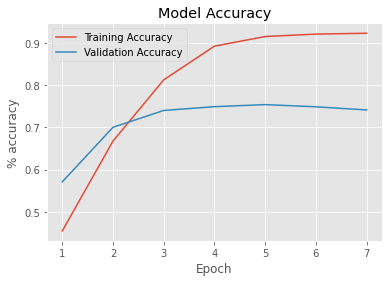

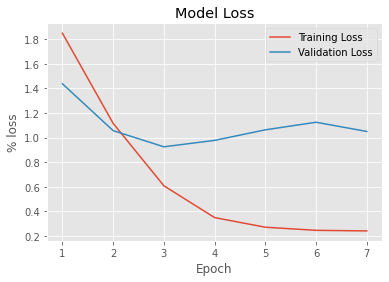

In [125]:
plot_model_results(model_2)

In [126]:
train_pred = model_2.predict(X_train)
test_pred = model_2.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9312248780557582
test accuracy = 0.7539764275088683


C:\Users\limbu\AppData\Local\Temp/ipykernel_17092/2592686746.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


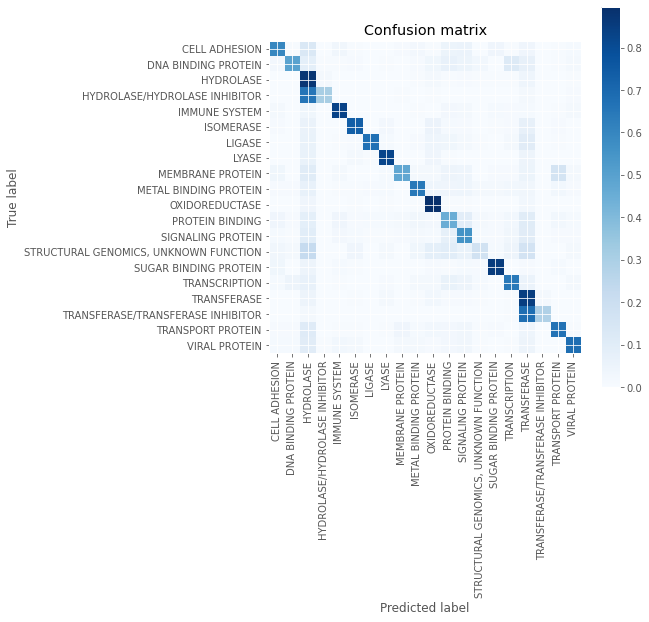

In [127]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [128]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.53      0.60      0.56       226
                  DNA BINDING PROTEIN       0.66      0.50      0.57       280
                            HYDROLASE       0.76      0.87      0.81      4111
        HYDROLASE/HYDROLASE INHIBITOR       0.71      0.31      0.43       536
                        IMMUNE SYSTEM       0.89      0.83      0.86       865
                            ISOMERASE       0.79      0.73      0.76       491
                               LIGASE       0.89      0.67      0.76       435
                                LYASE       0.85      0.82      0.84       827
                     MEMBRANE PROTEIN       0.74      0.47      0.58       336
                METAL BINDING PROTEIN       0.58      0.65      0.61       263
                       OXIDOREDUCTASE       0.87      0.90      0.88      2409
                      PROTEIN BINDING       0.35   

In [129]:
model_3 = Sequential()
model_3.add(Embedding(26, 20, input_length=285))

model_3.add(LSTM(25,
                 kernel_regularizer=l2(0.01),
                 recurrent_regularizer=l2(0.01),
                 bias_regularizer=l2(0.01),
                 return_sequences=True))

model_3.add(Flatten())
model_3.add(Dense(7125, activation='sigmoid'))
model_3.add(Dense(20, activation='softmax'))
model_3.add(Dropout(0.5))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 285, 20)           520       
                                                                 
 lstm_2 (LSTM)               (None, 285, 25)           4600      
                                                                 
 flatten_3 (Flatten)         (None, 7125)              0         
                                                                 
 dense_6 (Dense)             (None, 7125)              50772750  
                                                                 
 dense_7 (Dense)             (None, 20)                142520    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
Total params: 50,920,390
Trainable params: 50,920,390


In [130]:
model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=early_stopping)

Epoch 1/15
2185/2185 [==============================] - 542s 247ms/step - loss: 9.0293 - accuracy: 0.2364 - val_loss: 1.9086 - val_accuracy: 0.4322
Epoch 2/15
2185/2185 [==============================] - 549s 251ms/step - loss: 8.7640 - accuracy: 0.2891 - val_loss: 1.6705 - val_accuracy: 0.5049
Epoch 3/15
2185/2185 [==============================] - 546s 250ms/step - loss: 8.5616 - accuracy: 0.3346 - val_loss: 1.4426 - val_accuracy: 0.5807
Epoch 4/15
2185/2185 [==============================] - 545s 249ms/step - loss: 8.4837 - accuracy: 0.3706 - val_loss: 1.3002 - val_accuracy: 0.6378
Epoch 5/15
2185/2185 [==============================] - 548s 251ms/step - loss: 8.3663 - accuracy: 0.4030 - val_loss: 1.1728 - val_accuracy: 0.6758
Epoch 6/15
2185/2185 [==============================] - 547s 250ms/step - loss: 8.3039 - accuracy: 0.4257 - val_loss: 1.1265 - val_accuracy: 0.6991
Epoch 7/15
2185/2185 [==============================] - 546s 250ms/step - loss: 8.1964 - accuracy: 0.4446 - val_

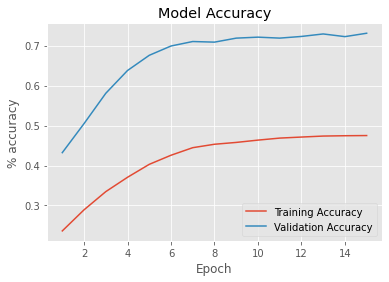

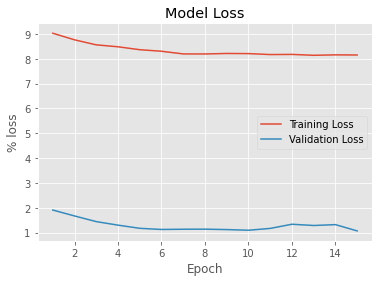

In [131]:
plot_model_results(model_3)

In [132]:
train_pred = model_3.predict(X_train)
test_pred = model_3.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9186799982834828
test accuracy = 0.7310332990044628


C:\Users\limbu\AppData\Local\Temp/ipykernel_17092/2592686746.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


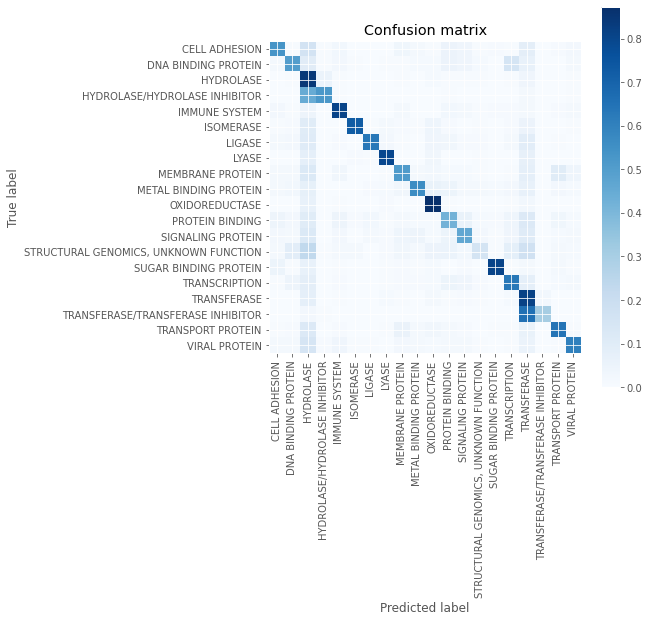

In [133]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [134]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.48      0.54      0.51       226
                  DNA BINDING PROTEIN       0.48      0.50      0.49       280
                            HYDROLASE       0.72      0.84      0.78      4111
        HYDROLASE/HYDROLASE INHIBITOR       0.55      0.52      0.54       536
                        IMMUNE SYSTEM       0.84      0.80      0.82       865
                            ISOMERASE       0.90      0.73      0.80       491
                               LIGASE       0.85      0.63      0.72       435
                                LYASE       0.86      0.79      0.82       827
                     MEMBRANE PROTEIN       0.50      0.51      0.51       336
                METAL BINDING PROTEIN       0.58      0.56      0.57       263
                       OXIDOREDUCTASE       0.88      0.87      0.88      2409
                      PROTEIN BINDING       0.39   

In [135]:
model_4 = Sequential()
model_4.add(Embedding(26, 20, input_length=285))

# can alter this as well (bigger = overfit)
model_4.add(LSTM(25, return_sequences=True))

model_4.add(Flatten())
# can play with this layer
model_4.add(Dense(7125, activation='sigmoid'))
model_4.add(Dense(20, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=5)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 285, 20)           520       
                                                                 
 lstm_3 (LSTM)               (None, 285, 25)           4600      
                                                                 
 flatten_4 (Flatten)         (None, 7125)              0         
                                                                 
 dense_8 (Dense)             (None, 7125)              50772750  
                                                                 
 dense_9 (Dense)             (None, 20)                142520    
                                                                 
Total params: 50,920,390
Trainable params: 50,920,390
Non-trainable params: 0
_________________________________________________________________


In [136]:
model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 545s 249ms/step - loss: 1.8534 - accuracy: 0.4546 - val_loss: 1.4473 - val_accuracy: 0.5693
Epoch 2/50
2185/2185 [==============================] - 543s 248ms/step - loss: 1.0653 - accuracy: 0.6811 - val_loss: 0.9939 - val_accuracy: 0.7150
Epoch 3/50
2185/2185 [==============================] - 541s 248ms/step - loss: 0.5495 - accuracy: 0.8316 - val_loss: 0.9750 - val_accuracy: 0.7410
Epoch 4/50
2185/2185 [==============================] - 542s 248ms/step - loss: 0.3254 - accuracy: 0.9016 - val_loss: 0.9548 - val_accuracy: 0.7495
Epoch 5/50
2185/2185 [==============================] - 542s 248ms/step - loss: 0.2760 - accuracy: 0.9167 - val_loss: 1.0324 - val_accuracy: 0.7447
Epoch 6/50
2185/2185 [==============================] - 544s 249ms/step - loss: 0.2650 - accuracy: 0.9201 - val_loss: 1.0723 - val_accuracy: 0.7457
Epoch 7/50
2185/2185 [==============================] - 545s 249ms/step - loss: 0.2691 - accuracy: 0.9203 - val_

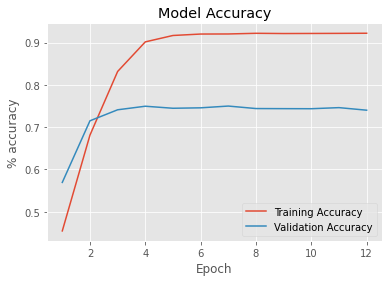

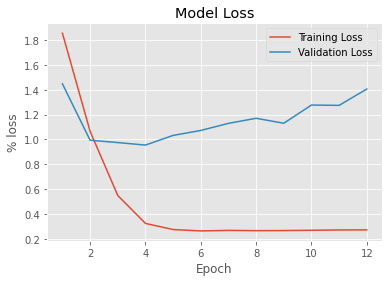

In [137]:
plot_model_results(model_4)

In [138]:
train_pred = model_4.predict(X_train)
test_pred = model_4.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9305525754909955
test accuracy = 0.7498569630392493


C:\Users\limbu\AppData\Local\Temp/ipykernel_17092/2592686746.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


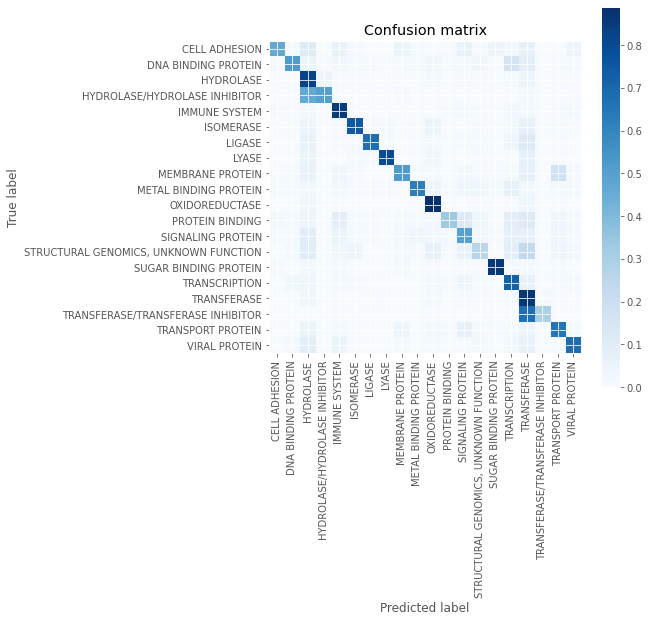

In [139]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [140]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.65      0.47      0.54       226
                  DNA BINDING PROTEIN       0.62      0.52      0.57       280
                            HYDROLASE       0.80      0.82      0.81      4111
        HYDROLASE/HYDROLASE INHIBITOR       0.58      0.50      0.54       536
                        IMMUNE SYSTEM       0.76      0.85      0.80       865
                            ISOMERASE       0.78      0.75      0.77       491
                               LIGASE       0.84      0.68      0.75       435
                                LYASE       0.93      0.79      0.86       827
                     MEMBRANE PROTEIN       0.58      0.52      0.55       336
                METAL BINDING PROTEIN       0.68      0.62      0.65       263
                       OXIDOREDUCTASE       0.89      0.89      0.89      2409
                      PROTEIN BINDING       0.66   

In [141]:
model_5 = Sequential()
model_5.add(Embedding(26, 20, input_length=285))

model_5.add(LSTM(30, return_sequences=True))

model_5.add(Flatten())
model_5.add(Dense(8550, activation='sigmoid'))
model_5.add(Dense(20, activation='softmax'))
model_5.add(Dropout(0.5))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=5)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 285, 20)           520       
                                                                 
 lstm_4 (LSTM)               (None, 285, 30)           6120      
                                                                 
 flatten_5 (Flatten)         (None, 8550)              0         
                                                                 
 dense_10 (Dense)            (None, 8550)              73111050  
                                                                 
 dense_11 (Dense)            (None, 20)                171020    
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
Total params: 73,288,710
Trainable params: 73,288,710


In [142]:
model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
2185/2185 [==============================] - 734s 335ms/step - loss: 9.0428 - accuracy: 0.2403 - val_loss: 1.7051 - val_accuracy: 0.4782
Epoch 2/50
2185/2185 [==============================] - 724s 331ms/step - loss: 8.6217 - accuracy: 0.3260 - val_loss: 1.3243 - val_accuracy: 0.6053
Epoch 3/50
2185/2185 [==============================] - 729s 334ms/step - loss: 8.3710 - accuracy: 0.3857 - val_loss: 1.1311 - val_accuracy: 0.6710
Epoch 4/50
2185/2185 [==============================] - 728s 333ms/step - loss: 8.3138 - accuracy: 0.4181 - val_loss: 1.1336 - val_accuracy: 0.6888
Epoch 5/50
2185/2185 [==============================] - 726s 332ms/step - loss: 8.2396 - accuracy: 0.4394 - val_loss: 1.1210 - val_accuracy: 0.7061
Epoch 6/50
2185/2185 [==============================] - 731s 334ms/step - loss: 8.2714 - accuracy: 0.4473 - val_loss: 1.0422 - val_accuracy: 0.7238
Epoch 7/50
2185/2185 [==============================] - 723s 331ms/step - loss: 8.1915 - accuracy: 0.4585 - val_

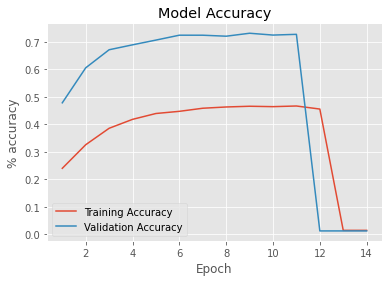

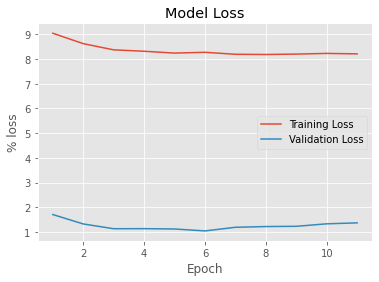

In [143]:
plot_model_results(model_5)

In [144]:
train_pred = model_5.predict(X_train)
test_pred = model_5.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9046045573531305
test accuracy = 0.7309188694358623


C:\Users\limbu\AppData\Local\Temp/ipykernel_17092/2592686746.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


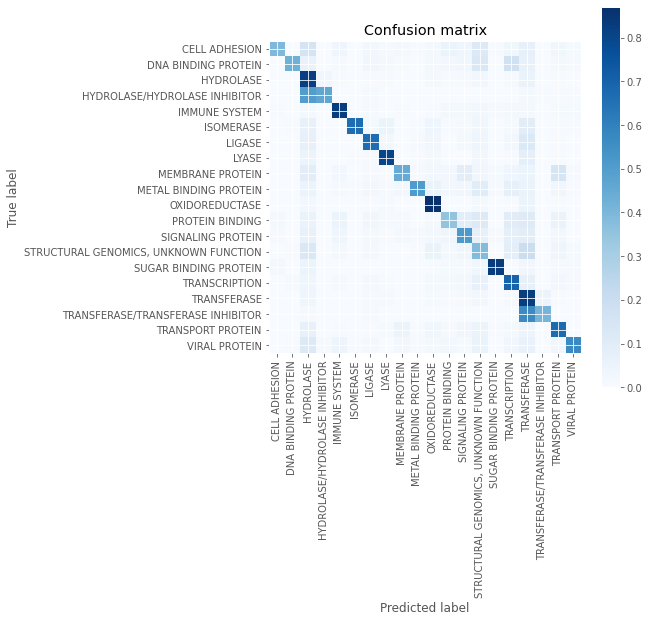

In [145]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [146]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                                       precision    recall  f1-score   support

                        CELL ADHESION       0.77      0.39      0.52       226
                  DNA BINDING PROTEIN       0.85      0.43      0.57       280
                            HYDROLASE       0.79      0.82      0.80      4111
        HYDROLASE/HYDROLASE INHIBITOR       0.64      0.46      0.54       536
                        IMMUNE SYSTEM       0.85      0.83      0.84       865
                            ISOMERASE       0.95      0.67      0.78       491
                               LIGASE       0.64      0.67      0.65       435
                                LYASE       0.83      0.80      0.81       827
                     MEMBRANE PROTEIN       0.65      0.44      0.53       336
                METAL BINDING PROTEIN       0.75      0.51      0.61       263
                       OXIDOREDUCTASE       0.88      0.87      0.88      2409
                      PROTEIN BINDING       0.46   

In [147]:
data

,sequence,classification,seq_char_count
40,PPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKAS...,TRANSFERASE/TRANSFERASE INHIBITOR,209
67,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,HYDROLASE,286
74,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...,LIGASE,330
76,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,HYDROLASE,124
78,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,HYDROLASE,124
...,...,...,...
471040,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,HYDROLASE/HYDROLASE INHIBITOR,99
471115,APVRSLNCTLRDSQQKSLVMSGPYELKALHLQGQDMEQQVVFSMSF...,SIGNALING PROTEIN,153
471118,STQAATASSRNSCAADDKATEPLPKDCPVSSYNEWDPLEEVIVGRA...,TRANSFERASE,386
471123,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,HYDROLASE/HYDROLASE INHIBITOR,198


In [148]:
data['classification'].value_counts()[:10]

HYDROLASE                        20383
TRANSFERASE                      15340
OXIDOREDUCTASE                   12173
LYASE                             4239
IMMUNE SYSTEM                     3989
TRANSCRIPTION                     3479
TRANSPORT PROTEIN                 3174
SIGNALING PROTEIN                 2845
HYDROLASE/HYDROLASE INHIBITOR     2650
ISOMERASE                         2531
Name: classification, dtype: int64

In [149]:
# only keep top 10 classifications
counts = data.classification.value_counts()
hello = np.asarray(counts[(counts > 2530)].index)

In [150]:
data_top10 = data[data.classification.isin(hello)]

In [151]:
X = data_top10['sequence']
y = data_top10['classification']

In [152]:
# encode classification labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [153]:
# encode sequences using tokenizer
# create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
# represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=285)

In [154]:
# number of distinct characters stored in variable max_id
# this will be part of the input shape (reps each AA)
max_id = len(tokenizer.word_index)
max_id

25

In [155]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# confirm shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56642, 285), (14161, 285), (56642, 10), (14161, 10))

In [156]:
model_6 = Sequential()
model_6.add(Embedding(26, 10, input_length=285))

model_6.add(LSTM(15, return_sequences=True))

model_6.add(Dropout(0.5))
model_6.add(Flatten())
model_6.add(Dense(4275, activation='sigmoid'))
model_6.add(Dense(10, activation='softmax'))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=5)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

model_6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 285, 10)           260       
                                                                 
 lstm_5 (LSTM)               (None, 285, 15)           1560      
                                                                 
 dropout_2 (Dropout)         (None, 285, 15)           0         
                                                                 
 flatten_6 (Flatten)         (None, 4275)              0         
                                                                 
 dense_12 (Dense)            (None, 4275)              18279900  
                                                                 
 dense_13 (Dense)            (None, 10)                42760     
                                                                 
Total params: 18,324,480
Trainable params: 18,324,480


In [157]:
model_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
1771/1771 [==============================] - 262s 147ms/step - loss: 1.6377 - accuracy: 0.4479 - val_loss: 1.3778 - val_accuracy: 0.5312
Epoch 2/50
1771/1771 [==============================] - 261s 147ms/step - loss: 1.3573 - accuracy: 0.5333 - val_loss: 1.2457 - val_accuracy: 0.5753
Epoch 3/50
1771/1771 [==============================] - 263s 149ms/step - loss: 1.1996 - accuracy: 0.5874 - val_loss: 1.0710 - val_accuracy: 0.6401
Epoch 4/50
1771/1771 [==============================] - 265s 150ms/step - loss: 0.9306 - accuracy: 0.6851 - val_loss: 0.8309 - val_accuracy: 0.7328
Epoch 5/50
1771/1771 [==============================] - 265s 150ms/step - loss: 0.6521 - accuracy: 0.7832 - val_loss: 0.6707 - val_accuracy: 0.7873
Epoch 6/50
1771/1771 [==============================] - 264s 149ms/step - loss: 0.4515 - accuracy: 0.8524 - val_loss: 0.5947 - val_accuracy: 0.8137
Epoch 7/50
1771/1771 [==============================] - 264s 149ms/step - loss: 0.3319 - accuracy: 0.8923 - val_

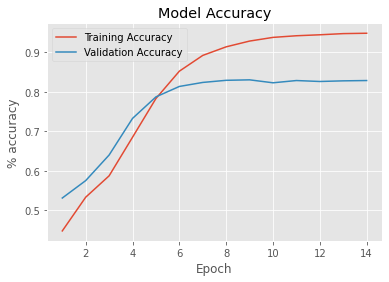

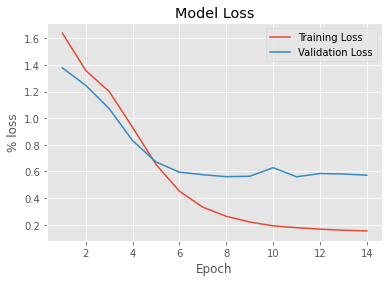

In [158]:
plot_model_results(model_6)

In [159]:
train_pred = model_6.predict(X_train)
test_pred = model_6.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train accuracy = 0.9567635323611454
test accuracy = 0.8304498269896193


C:\Users\limbu\AppData\Local\Temp/ipykernel_17092/2592686746.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


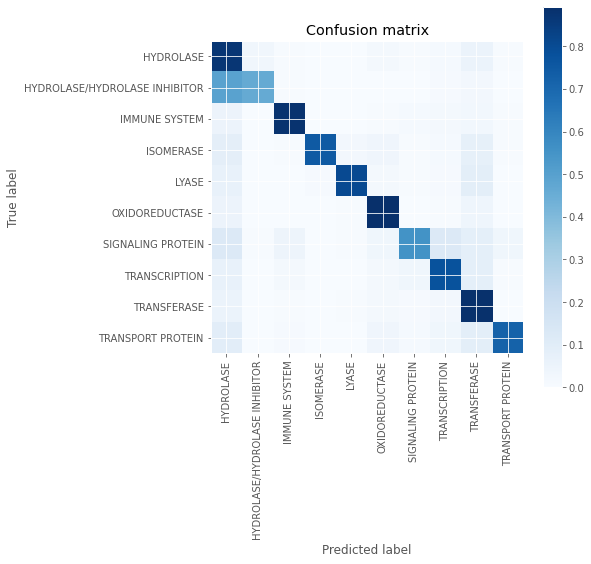

In [160]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [161]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

                               precision    recall  f1-score   support

                    HYDROLASE       0.81      0.87      0.84      4142
HYDROLASE/HYDROLASE INHIBITOR       0.65      0.46      0.54       509
                IMMUNE SYSTEM       0.88      0.88      0.88       753
                    ISOMERASE       0.96      0.75      0.84       512
                        LYASE       0.92      0.80      0.86       849
               OXIDOREDUCTASE       0.91      0.89      0.90      2376
            SIGNALING PROTEIN       0.75      0.55      0.64       601
                TRANSCRIPTION       0.68      0.78      0.72       706
                  TRANSFERASE       0.81      0.89      0.85      3091
            TRANSPORT PROTEIN       0.89      0.72      0.80       622

                     accuracy                           0.83     14161
                    macro avg       0.83      0.76      0.79     14161
                 weighted avg       0.83      0.83      0.83     14161

